In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from neo4j import GraphDatabase
import warnings

In [2]:
warnings.filterwarnings("ignore")

# Set visualization style
plt.style.use("ggplot")
sns.set(style="whitegrid")

# 1. Load essential datasets
print("Loading datasets...")

# Main trial dataset (contains our target variable 'outcome')
covid_trial_df = pd.read_csv(
    "/home/prerakshah/Documents/MASTERS/A_DATABASE/Project_2/clinical_trial_graph-master/neo4j_data/covidtrial.csv"
)

# Load supplementary datasets
condition_df = pd.read_csv(
    "/home/prerakshah/Documents/MASTERS/A_DATABASE/Project_2/clinical_trial_graph-master/neo4j_data/condition.csv"
)
condition_include_df = pd.read_csv(
    "/home/prerakshah/Documents/MASTERS/A_DATABASE/Project_2/clinical_trial_graph-master/neo4j_data/condition_relation_include.csv"
)
drug_df = pd.read_csv(
    "/home/prerakshah/Documents/MASTERS/A_DATABASE/Project_2/clinical_trial_graph-master/neo4j_data/drug.csv"
)
drug_include_df = pd.read_csv(
    "/home/prerakshah/Documents/MASTERS/A_DATABASE/Project_2/clinical_trial_graph-master/neo4j_data/drug_relation_include.csv"
)
sponsor_df = pd.read_csv(
    "/home/prerakshah/Documents/MASTERS/A_DATABASE/Project_2/clinical_trial_graph-master/neo4j_data/sponsor.csv"
)
sponsor_relation_df = pd.read_csv(
    "/home/prerakshah/Documents/MASTERS/A_DATABASE/Project_2/clinical_trial_graph-master/neo4j_data/sponsor_relation.csv"
)
location_df = pd.read_csv(
    "/home/prerakshah/Documents/MASTERS/A_DATABASE/Project_2/clinical_trial_graph-master/neo4j_data/location.csv"
)
loc_relation_df = pd.read_csv(
    "/home/prerakshah/Documents/MASTERS/A_DATABASE/Project_2/clinical_trial_graph-master/neo4j_data/loc_relation.csv"
)


# Set visualization style
plt.style.use("ggplot")
sns.set(style="whitegrid")

# # 1. Neo4j Connection Setup
# # Replace with your Neo4j credentials
# NEO4J_URI = "bolt://localhost:7687"
# NEO4J_USER = "neo4j"
# NEO4J_PASSWORD = "password"  # Replace with your password


# class Neo4jConnection:
#     def __init__(self, uri, user, password):
#         self.driver = GraphDatabase.driver(uri, auth=(user, password))

#     def close(self):
#         self.driver.close()

#     def run_query(self, query, parameters=None):
#         with self.driver.session() as session:
#             result = session.run(query, parameters)
#             return [record for record in result]


# # Initialize connection
# neo4j_conn = Neo4jConnection(NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD)

# # 2. Load data from Neo4j
# print("Loading data from Neo4j...")

# # Query to get clinical trial data
# query_clinical_trials = """
# MATCH (trial:ClinicalTrial)
# RETURN trial.id AS trial_id,
#        trial.title AS Title,
#        trial.acronym AS Acronym,
#        trial.status AS Status,
#        trial.phase AS Phases,
#        trial.url AS URL,
#        trial.study_type AS study_type
# """
# trials_data = neo4j_conn.run_query(query_clinical_trials)
# covid_trial_df = pd.DataFrame([dict(record) for record in trials_data])

# # Load trial outcomes from CSV (assuming this is not in Neo4j yet)
# # You should update this to fetch from Neo4j if available
# outcomes_df = pd.read_csv(
#     "covidtrial.csv", usecols=["trial_id", "outcome", "study_design", "Funded Bys"]
# )
# covid_trial_df = pd.merge(covid_trial_df, outcomes_df, on="trial_id", how="left")


# # Function to fetch relationships for a trial
# def fetch_relationships(
#     relationship_type, entity_type, id_property="id", name_property="name"
# ):
#     query = f"""
#     MATCH (trial:ClinicalTrial)-[:{relationship_type}]->(entity:{entity_type})
#     RETURN trial.id AS trial_id,
#            entity.{id_property} AS entity_id,
#            entity.{name_property} AS entity_name
#     """
#     records = neo4j_conn.run_query(query)
#     return pd.DataFrame([dict(record) for record in records])


# # Fetch conditions
# print("Fetching conditions data...")
# condition_include_df = fetch_relationships("INCLUDE_CONDITION", "Condition")
# condition_include_df.columns = ["covidtrialID", "conditionOMOPID", "conditionOMOPName"]

# # Fetch drugs
# print("Fetching drugs data...")
# drug_include_df = fetch_relationships("INCLUDE_DRUG", "Drug")
# drug_include_df.columns = ["covidtrialID", "drugOMOPID", "drugOMOPName"]

# # Fetch sponsors
# print("Fetching sponsors data...")
# sponsor_df = fetch_relationships("HAS_SPONSOR", "Sponsor")
# sponsor_df.columns = ["covidtrialID", "sponsorID", "sponsorName"]

# # Fetch locations
# print("Fetching locations data...")
# location_df = fetch_relationships("HAS_LOCATION", "Location")
# location_df.columns = ["covidtrialID", "locationID", "locationName"]

# # 3. Data exploration
# print("\n--- COVID Trial Dataset Overview ---")
# print(f"Total trials: {covid_trial_df.shape[0]}")
# print("\nMissing values per column:")
# print(covid_trial_df.isnull().sum())

# print("\nOutcome distribution:")
# outcome_counts = covid_trial_df["outcome"].value_counts()
# print(outcome_counts)

Loading datasets...


In [3]:
# 2. Data exploration
print("\n--- COVID Trial Dataset Overview ---")
print(f"Total trials: {covid_trial_df.shape[0]}")
print("\nMissing values per column:")
print(covid_trial_df.isnull().sum())

print("\nOutcome distribution:")
outcome_counts = covid_trial_df["outcome"].value_counts()
print(outcome_counts)

# Visualize outcome distribution
plt.figure(figsize=(12, 8))
ax = sns.countplot(y=covid_trial_df["outcome"].str.split("\\|").str[0])
ax.set_title("Distribution of Primary Trial Outcomes", fontsize=16)
ax.set_xlabel("Count", fontsize=12)
ax.set_ylabel("Primary Outcome", fontsize=12)
plt.tight_layout()
plt.savefig("outcome_distribution.png")
plt.close()


--- COVID Trial Dataset Overview ---
Total trials: 3392

Missing values per column:
Title               0
Acronym          1873
Status              0
Study Results       0
Phases           1474
Funded Bys          0
URL                 0
trial_id            0
outcome            25
study_type          0
study_design       25
dtype: int64

Outcome distribution:
outcome
mortality                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [4]:
# 3. Feature Engineering


# Create a function to merge related tables and create aggregated features
def create_aggregated_features(
    main_df, relation_df, entity_df, relation_col, entity_col, name_col, prefix
):
    # Merge relation table with entity table to get entity names
    relation_entity_df = pd.merge(
        relation_df, entity_df, left_on=relation_col, right_on=entity_col, how="left"
    )

    # Group by trial ID and aggregate entity names
    grouped_df = (
        relation_entity_df.groupby("covidtrialID")[name_col].apply(list).reset_index()
    )
    grouped_df[f"{prefix}_count"] = grouped_df[name_col].apply(len)

    # Also create a text column for TF-IDF later
    grouped_df[f"{prefix}_text"] = grouped_df[name_col].apply(
        lambda x: " ".join(str(item) for item in x)
    )

    # Merge aggregated data back to main dataframe
    result_df = pd.merge(
        main_df,
        grouped_df,
        left_on="trial_id",
        right_on="covidtrialID",
        how="left",
        suffixes=("", f"_{prefix}"),
    )
    if f"covidtrialID_{prefix}" in result_df.columns:
        result_df = result_df.drop(f"covidtrialID_{prefix}", axis=1)
    # Fill NaN values
    result_df[name_col] = result_df[name_col].apply(
        lambda x: [] if isinstance(x, float) and np.isnan(x) else x
    )
    result_df[f"{prefix}_count"] = result_df[f"{prefix}_count"].fillna(0)
    result_df[f"{prefix}_text"] = result_df[f"{prefix}_text"].fillna("")

    return result_df

In [5]:
# Create aggregated features for conditions
print("\nCreating condition features...")
enriched_df = create_aggregated_features(
    covid_trial_df,
    condition_include_df,
    condition_df,
    "conditionOMOPID",
    "conditionOMOPID",
    "conditionOMOPName",
    "condition",
)

# Create aggregated features for drugs
print("Creating drug features...")
enriched_df = create_aggregated_features(
    enriched_df,
    drug_include_df,
    drug_df,
    "drugOMOPID",
    "drugOMOPID",
    "drugOMOPName",
    "drug",
)

# Create aggregated features for sponsors
print("Creating sponsor features...")
enriched_df = create_aggregated_features(
    enriched_df,
    sponsor_relation_df,
    sponsor_df,
    "sponsorID",
    "sponsorID",
    "sponsorName",
    "sponsor",
)

# Create aggregated features for locations
print("Creating location features...")
enriched_df = create_aggregated_features(
    enriched_df,
    loc_relation_df,
    location_df,
    "locationID",
    "locationID",
    "locationName",
    "location",
)

# 4. Process categorical and text features
print("\nProcessing categorical and text features...")

# Extract the primary outcome (first part before '|')
enriched_df["primary_outcome"] = enriched_df["outcome"].str.split("\\|").str[0]

# Explore the distribution of primary outcomes
print("\nPrimary outcome distribution:")
primary_outcome_counts = enriched_df["primary_outcome"].value_counts()
print(primary_outcome_counts.head(10))  # Show top 10 outcomes

# Categorize outcomes into broader categories for better prediction
# This requires domain knowledge - using a simple approach here
outcome_categories = {
    "mortality": ["mortality", "death", "survival", "overall survival"],
    "clinical_improvement": [
        "clinical improvement",
        "recovery",
        "time to recovery",
        "clinical response",
        "response",
    ],
    # "hospitalization": ["hospital", "hospitalization", "length of stay", "discharge"],
    "adverse_events": ["adverse", "safety", "toxicity", "side effects"],
    "viral_clearance": ["viral", "clearance", "pcr negative", "viral load"],
    # "symptoms": ["symptoms", "fever", "respiratory", "breathing", "oxygen"],
    "biomarkers": ["biomarker", "c-reactive", "cytokine", "inflammatory"],
    "other": [],  # Default category
}
# outcome_categories = {
#     "Success": [
#         "significant improvement",
#         "effective",
#         "efficacy demonstrated",
#         "positive results",
#         "successful",
#         "met primary endpoint",
#         "statistical significance",
#         "superior to",
#         "positive outcome",
#         "reduction in mortality",
#         "increased survival",
#         "beneficial effect",
#     ],
#     "Failure": [
#         "no significant",
#         "not effective",
#         "failed to demonstrate",
#         "no difference",
#         "did not meet",
#         "no improvement",
#         "discontinued",
#         "negative results",
#         "ineffective",
#         "no statistical significance",
#         "no benefit",
#         "not superior to",
#         "no effect",
#         "terminated early",
#     ],
# }


# Trial success keywords - more specific to clinical efficacy


# Trial failure keywords - indicates lack of efficacy or issues


Creating condition features...
Creating drug features...
Creating sponsor features...
Creating location features...

Processing categorical and text features...

Primary outcome distribution:
primary_outcome
mortality                       39
time to clinical improvement    18
clinical improvement            14
all-cause mortality             13
time to recovery                11
death                           11
in-hospital mortality            8
survival                         7
overall survival                 7
mortality rate                   7
Name: count, dtype: int64


In [6]:
def categorize_outcome(outcome_text):
    if pd.isna(outcome_text):
        return "unknown"

    outcome_lower = outcome_text.lower()

    for category, keywords in outcome_categories.items():
        if any(keyword in outcome_lower for keyword in keywords):
            return category

    return "other"

In [7]:
enriched_df["outcome_category"] = enriched_df["primary_outcome"].apply(
    categorize_outcome
)

print("\nOutcome category distribution:")
print(enriched_df["outcome_category"].value_counts())

# Visualize outcome categories
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    y="outcome_category",
    data=enriched_df,
    order=enriched_df["outcome_category"].value_counts().index,
)
ax.set_title("Distribution of Outcome Categories", fontsize=16)
ax.set_xlabel("Count", fontsize=12)
ax.set_ylabel("Outcome Category", fontsize=12)
plt.tight_layout()
plt.savefig("outcome_categories.png")
plt.close()

# 5. Extract features from study design and phases
print("\nExtracting features from study design and phases...")

# Extract study allocation method (randomized, non-randomized, etc.)
enriched_df["allocation"] = enriched_df["study_design"].str.extract(
    r"allocation: ([^|]+)"
)

# Extract intervention model
enriched_df["intervention_model"] = enriched_df["study_design"].str.extract(
    r"intervention model: ([^|]+)"
)


Outcome category distribution:
outcome_category
other                   2504
mortality                379
adverse_events           182
clinical_improvement     171
viral_clearance          106
biomarkers                25
unknown                   25
Name: count, dtype: int64

Extracting features from study design and phases...


In [8]:
# Process phases - simplify to single phase or multi-phase
def simplify_phases(phase):
    if pd.isna(phase):
        return "unknown"
    if "|" in phase:
        return "multi_phase"
    return phase


enriched_df["simplified_phase"] = enriched_df["Phases"].apply(simplify_phases)

# 6. Preprocessing
print("\nPreprocessing data...")

# Select features for model
categorical_features = [
    "Status",
    "simplified_phase",
    "Funded Bys",
    "study_type",
    "allocation",
    "intervention_model",
]
text_features = ["condition_text", "drug_text", "sponsor_text", "location_text"]
numerical_features = [
    "condition_count",
    "drug_count",
    "sponsor_count",
    "location_count",
]

# Encode the target variable
label_encoder = LabelEncoder()
enriched_df["outcome_encoded"] = label_encoder.fit_transform(
    enriched_df["outcome_category"]
)
outcome_mapping = dict(
    zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))
)
print("\nOutcome category mapping:")
print(outcome_mapping)

# Prepare for categorical features
categorical_encoder = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
        ("onehot", pd.get_dummies),
    ]
)


Preprocessing data...

Outcome category mapping:
{'adverse_events': 0, 'biomarkers': 1, 'clinical_improvement': 2, 'mortality': 3, 'other': 4, 'unknown': 5, 'viral_clearance': 6}


In [9]:
# Apply TF-IDF to text features
def get_tfidf_features(df, column, max_features=100):
    tfidf = TfidfVectorizer(max_features=max_features, stop_words="english")
    tfidf_matrix = tfidf.fit_transform(df[column].fillna(""))
    tfidf_df = pd.DataFrame(
        tfidf_matrix.toarray(),
        columns=[f"{column}_{i}" for i in range(tfidf_matrix.shape[1])],
    )
    return tfidf_df


# Process each text feature
all_features = []

# Process numerical features
numerical_df = enriched_df[numerical_features].copy()
numerical_df = numerical_df.fillna(0)
scaler = StandardScaler()
numerical_scaled = pd.DataFrame(
    scaler.fit_transform(numerical_df), columns=numerical_features
)
all_features.append(numerical_scaled)

# Process categorical features
for cat_feature in categorical_features:
    if cat_feature in enriched_df.columns:
        cat_dummies = pd.get_dummies(
            enriched_df[cat_feature].fillna("unknown"),
            prefix=cat_feature,
            drop_first=True,
        )
        all_features.append(cat_dummies)

# Process text features
for text_feature in text_features:
    if text_feature in enriched_df.columns:
        tfidf_df = get_tfidf_features(enriched_df, text_feature, max_features=50)
        all_features.append(tfidf_df)

In [10]:
# Combine all features
X = pd.concat(all_features, axis=1)
y = enriched_df["outcome_encoded"]

print(f"\nFinal feature set shape: {X.shape}")

# 7. Split data into train and test sets
print("\nSplitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# 8. Train and evaluate models
print("\n--- Training and Evaluating Models ---")


Final feature set shape: (3392, 256)

Splitting data into train and test sets...

--- Training and Evaluating Models ---


In [11]:
# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")

    # Classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_,
    )
    plt.title(f"{model_name} Confusion Matrix", fontsize=16)
    plt.ylabel("True Label", fontsize=12)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_confusion_matrix.png')
    plt.close()

    return model, accuracy

In [12]:
# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, class_weight="balanced")
lr_model, lr_accuracy = evaluate_model(
    lr_model, X_train, X_test, y_train, y_test, "Logistic Regression"
)

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100, random_state=42, class_weight="balanced"
)
rf_model, rf_accuracy = evaluate_model(
    rf_model, X_train, X_test, y_train, y_test, "Random Forest"
)
XGB_model = XGBClassifier(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.14,
    min_child_weight=5,
    gamma=0.3,
    subsample=1,
    random_state=42,
    reg_lambda=25,
    reg_alpha=25,
    #   class_weight={0: class_weight[0], 1: class_weight[1]}
)
xgb_model, xgb_accuracy = evaluate_model(
    XGB_model, X_train, X_test, y_train, y_test, "XG boost"
)

# Compare model performances
print("\n--- Model Comparison ---")
models = ["Logistic Regression", "Random Forest", "XG Boost"]
accuracies = [lr_accuracy, rf_accuracy, xgb_accuracy]

Logistic Regression Accuracy: 0.4493

Logistic Regression Classification Report:
                      precision    recall  f1-score   support

      adverse_events       0.29      0.64      0.40        45
          biomarkers       0.02      0.17      0.03         6
clinical_improvement       0.12      0.33      0.18        43
           mortality       0.25      0.38      0.30        95
               other       0.87      0.46      0.60       626
             unknown       1.00      0.83      0.91         6
     viral_clearance       0.07      0.26      0.12        27

            accuracy                           0.45       848
           macro avg       0.37      0.44      0.36       848
        weighted avg       0.70      0.45      0.52       848

Random Forest Accuracy: 0.7347

Random Forest Classification Report:
                      precision    recall  f1-score   support

      adverse_events       0.65      0.24      0.35        45
          biomarkers       0.00      0.0

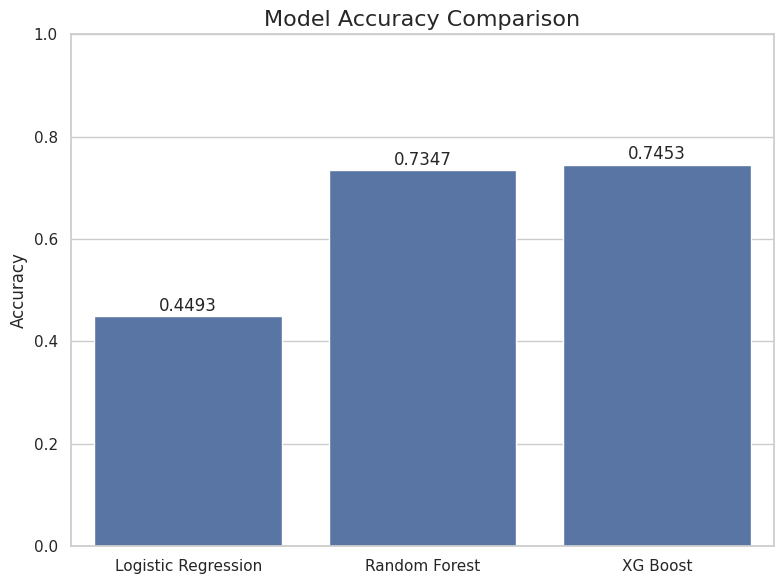

In [13]:
plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=accuracies)
plt.title("Model Accuracy Comparison", fontsize=16)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1.0)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.4f}", ha="center")
plt.tight_layout()
# plt.savefig("model_comparison.png")
plt.show()
plt.close()


--- Feature Importance Analysis (Random Forest) ---


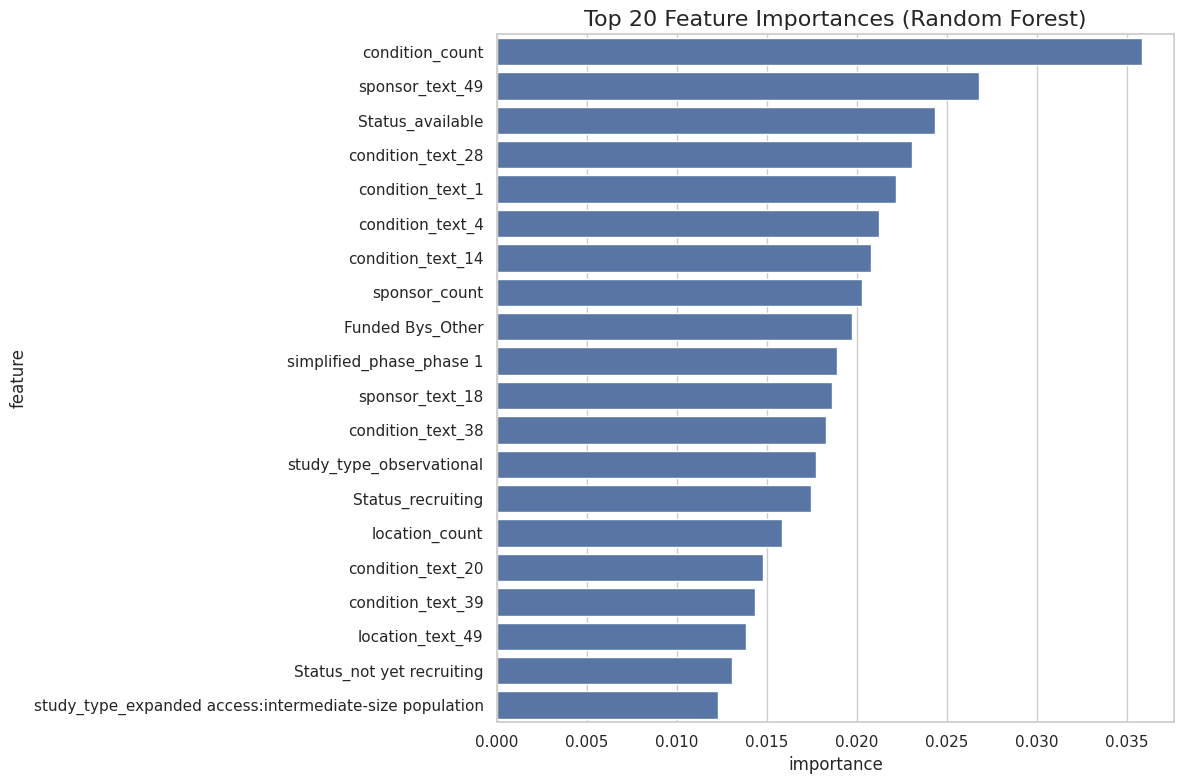

In [14]:
# 9. Feature importance analysis for Random Forest
print("\n--- Feature Importance Analysis (Random Forest) ---")
feature_importances = pd.DataFrame(
    {"feature": X.columns, "importance": rf_model.feature_importances_}
)
feature_importances = feature_importances.sort_values(
    "importance", ascending=False
).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x="importance", y="feature", data=feature_importances)
plt.title("Top 20 Feature Importances (Random Forest)", fontsize=16)
plt.tight_layout()
# plt.savefig("feature_importances.png")
plt.show()
plt.close()


--- Study Characteristics by Outcome Category ---


<Figure size 1200x800 with 0 Axes>

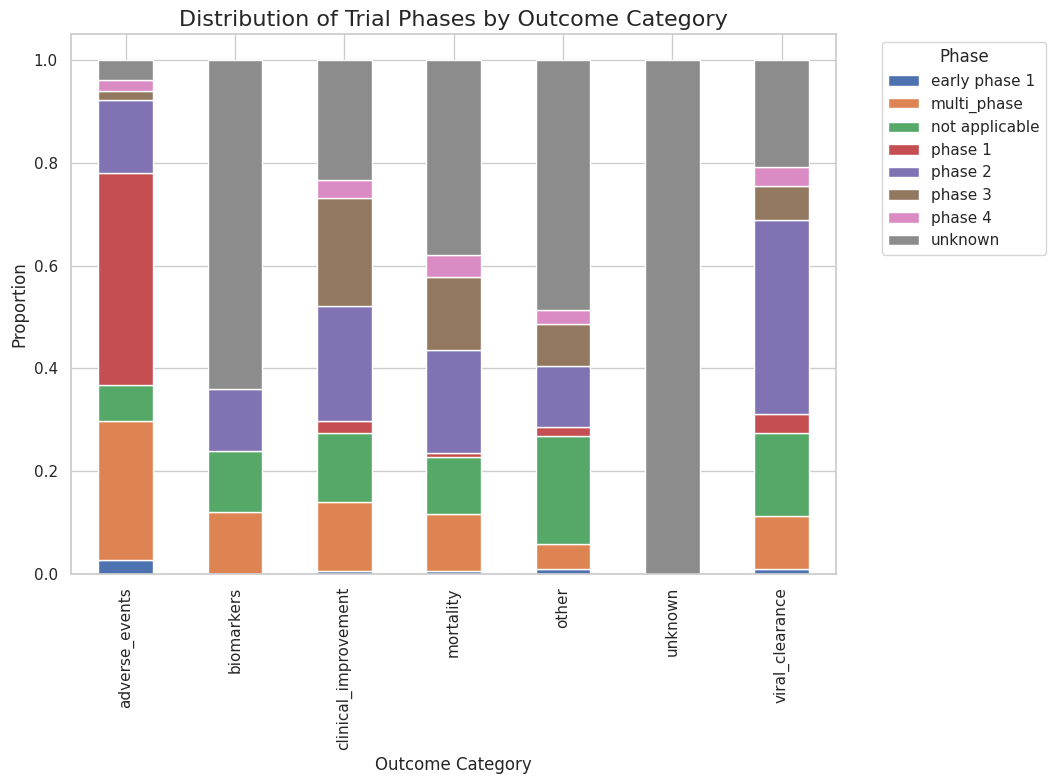

In [15]:
# 10. Study characteristics by outcome category
print("\n--- Study Characteristics by Outcome Category ---")

# Phase distribution by outcome
plt.figure(figsize=(12, 8))
phases_by_outcome = pd.crosstab(
    enriched_df["outcome_category"], enriched_df["simplified_phase"]
)
phases_by_outcome_pct = phases_by_outcome.div(phases_by_outcome.sum(axis=1), axis=0)
phases_by_outcome_pct.plot(kind="bar", stacked=True, figsize=(12, 8))
plt.title("Distribution of Trial Phases by Outcome Category", fontsize=16)
plt.xlabel("Outcome Category", fontsize=12)
plt.ylabel("Proportion", fontsize=12)
plt.legend(title="Phase")
# plt.tight_layout()
plt.legend(
    title="Phase", bbox_to_anchor=(1.05, 1), loc="upper left"
)  # Move legend outside
plt.tight_layout(rect=[0, 0, 0.9, 1])
# plt.savefig("phases_by_outcome.png")
plt.show()
plt.close()

<Figure size 1200x800 with 0 Axes>

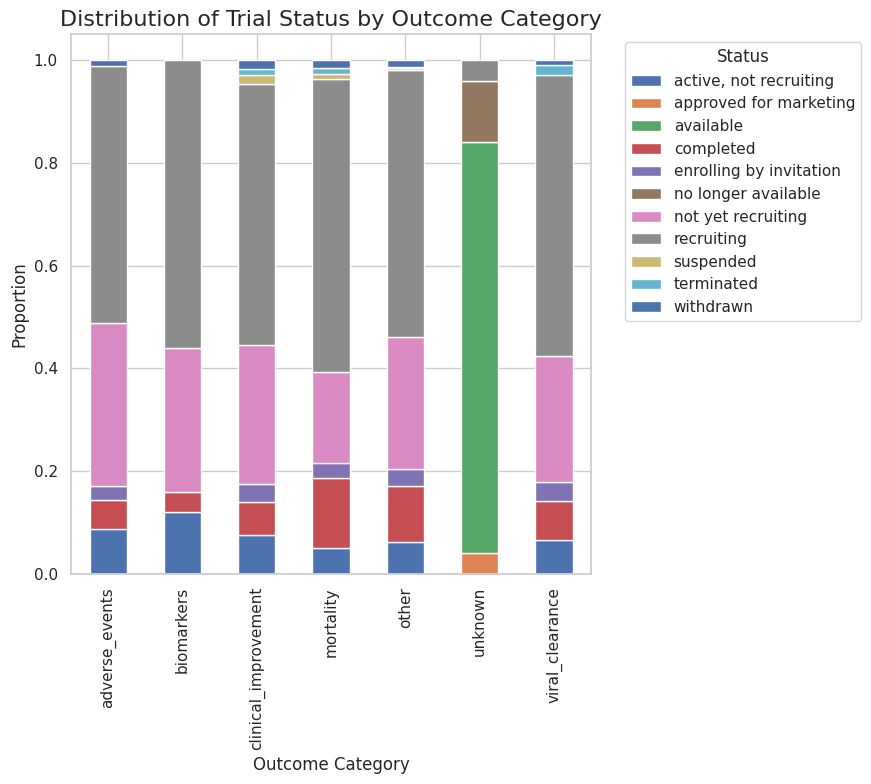

In [16]:
# Study status by outcome
plt.figure(figsize=(12, 8))
status_by_outcome = pd.crosstab(enriched_df["outcome_category"], enriched_df["Status"])
status_by_outcome_pct = status_by_outcome.div(status_by_outcome.sum(axis=1), axis=0)
status_by_outcome_pct.plot(kind="bar", stacked=True, figsize=(10, 8))
plt.title("Distribution of Trial Status by Outcome Category", fontsize=16)
plt.xlabel("Outcome Category", fontsize=12)
plt.ylabel("Proportion", fontsize=12)
# plt.legend(title="Status")
# plt.tight_layout()


plt.legend(
    title="Status", bbox_to_anchor=(1.05, 1), loc="upper left"
)  # Move legend outside
plt.tight_layout(rect=[0, 0, 0.9, 1])
# plt.savefig("status_by_outcome.png")
plt.show()
plt.close()

<Figure size 1200x800 with 0 Axes>

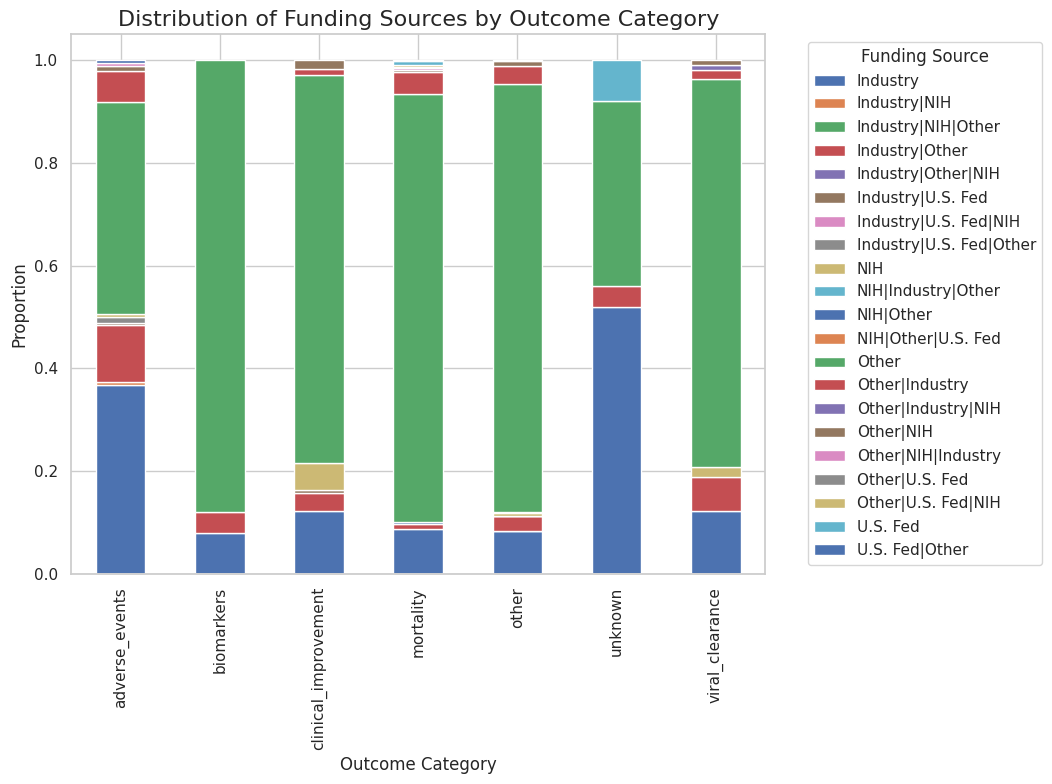

In [17]:
# Study funding by outcome
plt.figure(figsize=(12, 8))
funding_by_outcome = pd.crosstab(
    enriched_df["outcome_category"], enriched_df["Funded Bys"]
)
funding_by_outcome_pct = funding_by_outcome.div(funding_by_outcome.sum(axis=1), axis=0)
funding_by_outcome_pct.plot(kind="bar", stacked=True, figsize=(12, 8))
plt.title("Distribution of Funding Sources by Outcome Category", fontsize=16)
plt.xlabel("Outcome Category", fontsize=12)
plt.ylabel("Proportion", fontsize=12)
plt.legend(
    title="Funding Source", bbox_to_anchor=(1.05, 1), loc="upper left"
)  # Move legend outside
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit legend
# plt.savefig("funding_by_outcome.png")
plt.show()
plt.close()

In [18]:
# # 11. Correlation matrix of numerical features
# print("\n--- Correlation Analysis ---")
# numerical_corr = enriched_df[numerical_features].corr()
# plt.figure(figsize=(10, 8))
# sns.heatmap(numerical_corr, annot=True, cmap="coolwarm", fmt=".2f")
# plt.title("Correlation Matrix of Numerical Features", fontsize=16)
# plt.tight_layout()
# # plt.savefig("correlation_matrix.png")
# plt.show()
# plt.close()


--- Drug and Condition Analysis ---


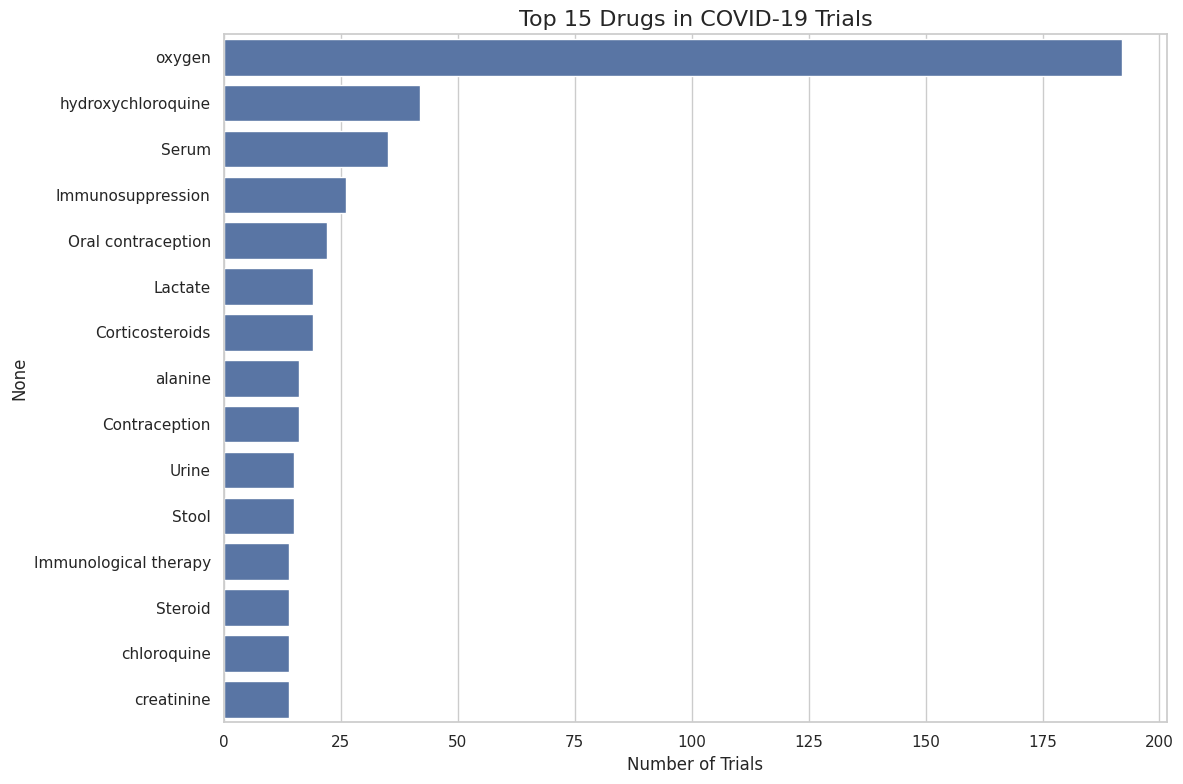

In [19]:
# 12. Drug and condition analysis
print("\n--- Drug and Condition Analysis ---")

# Most common drugs in trials
if "drugOMOPName" in enriched_df.columns:
    all_drugs = []
    for drugs in enriched_df["drugOMOPName"].dropna():
        if isinstance(drugs, list):
            all_drugs.extend(drugs)

    drug_counts = pd.Series(all_drugs).value_counts().head(15)
    plt.figure(figsize=(12, 8))
    sns.barplot(x=drug_counts.values, y=drug_counts.index)
    plt.title("Top 15 Drugs in COVID-19 Trials", fontsize=16)
    plt.xlabel("Number of Trials", fontsize=12)
    plt.tight_layout()
    # plt.savefig("top_drugs.png")
    plt.show()
    plt.close()

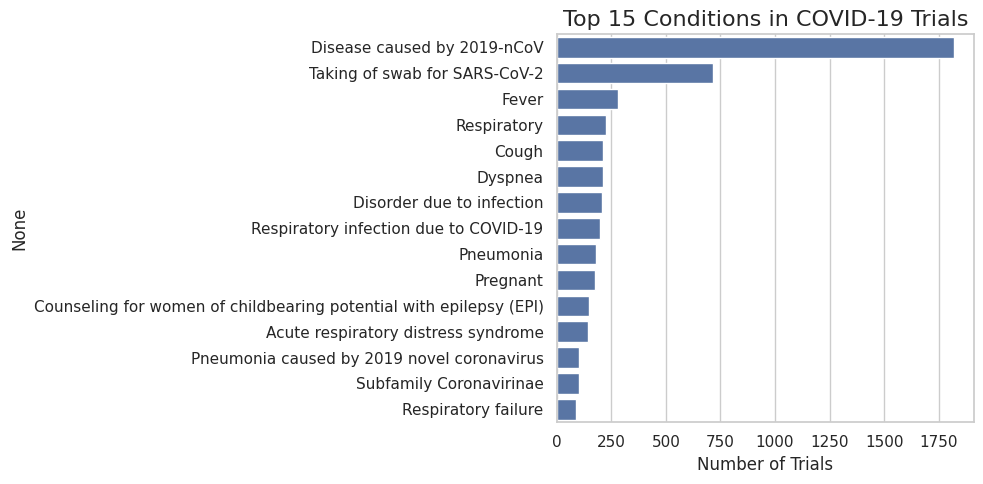

In [20]:
# Most common conditions in trials
if "conditionOMOPName" in enriched_df.columns:
    all_conditions = []
    for conditions in enriched_df["conditionOMOPName"].dropna():
        if isinstance(conditions, list):
            all_conditions.extend(conditions)

    condition_counts = pd.Series(all_conditions).value_counts().head(15)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=condition_counts.values, y=condition_counts.index)
    plt.title("Top 15 Conditions in COVID-19 Trials", fontsize=16)
    plt.xlabel("Number of Trials", fontsize=12)
    plt.tight_layout()
    # plt.savefig("top_conditions.png")
    plt.show()
    plt.close()

In [21]:
# 13. Study characteristics by model performance
print("\n--- Model Performance Analysis ---")

# Get predictions from both models
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_xg = xgb_model.predict(X_test)

# Create a DataFrame with test samples and predictions
test_indices = X_test.index
performance_df = pd.DataFrame(
    {
        "true_outcome": y_test,
        "lr_prediction": y_pred_lr,
        "rf_prediction": y_pred_rf,
        "xg_prediction": y_pred_xg,
        "lr_correct": y_test == y_pred_lr,
        "rf_correct": y_test == y_pred_rf,
        "xg_correct": y_test == y_pred_xg,
    }
)

# Merge with original data
performance_analysis = pd.merge(
    enriched_df.iloc[test_indices].reset_index(),
    performance_df.reset_index(),
    left_index=True,
    right_index=True,
)


--- Model Performance Analysis ---



LR Model Analysis:
Accuracy by outcome category:
outcome_category
adverse_events          0.644444
biomarkers              0.166667
clinical_improvement    0.325581
mortality               0.378947
other                   0.461661
unknown                 0.833333
viral_clearance         0.259259
Name: lr_correct, dtype: float64


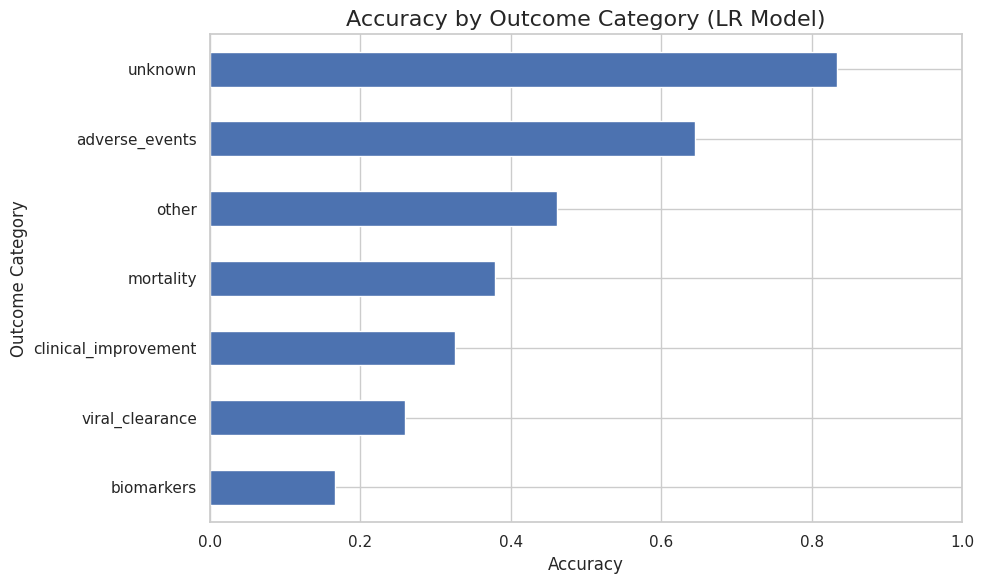

Accuracy by trial phase:
simplified_phase
early phase 1     0.142857
multi_phase       0.202703
not applicable    0.506098
phase 1           0.571429
phase 2           0.168142
phase 3           0.266667
phase 4           0.347826
unknown           0.601648
Name: lr_correct, dtype: float64


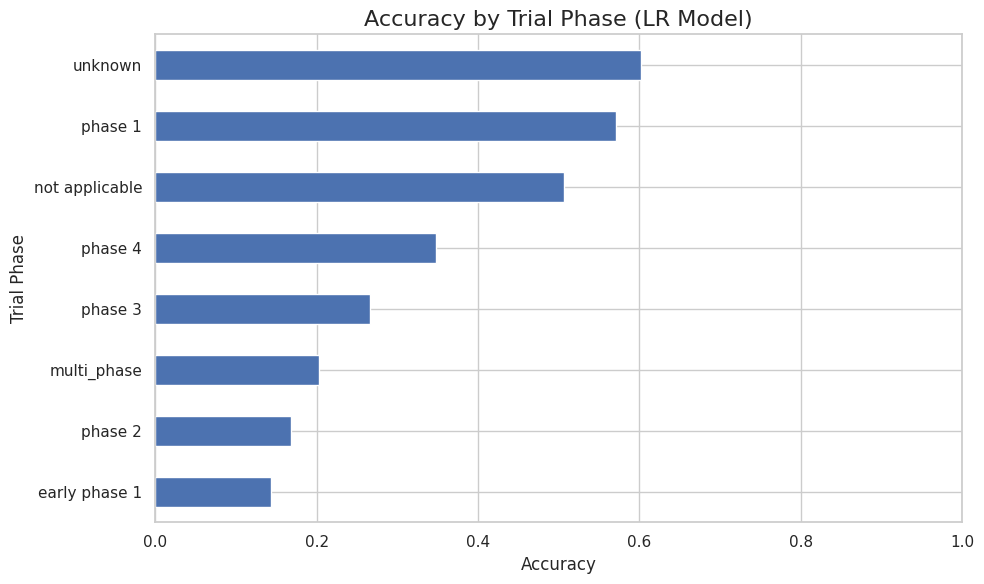


RF Model Analysis:
Accuracy by outcome category:
outcome_category
adverse_events          0.244444
biomarkers              0.000000
clinical_improvement    0.000000
mortality               0.063158
other                   0.958466
unknown                 0.833333
viral_clearance         0.037037
Name: rf_correct, dtype: float64


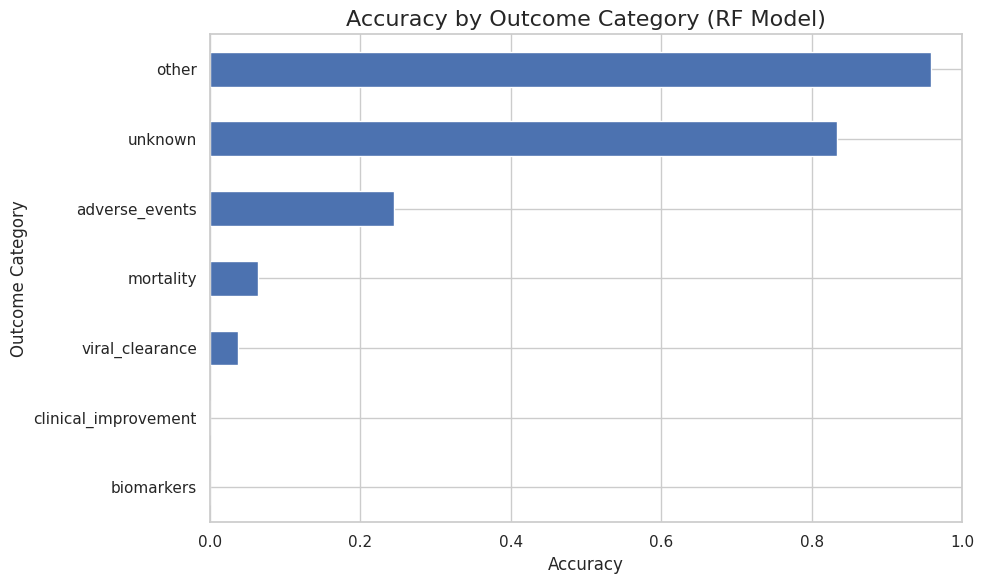

Accuracy by trial phase:
simplified_phase
early phase 1     0.714286
multi_phase       0.391892
not applicable    0.865854
phase 1           0.571429
phase 2           0.681416
phase 3           0.680000
phase 4           0.608696
unknown           0.793956
Name: rf_correct, dtype: float64


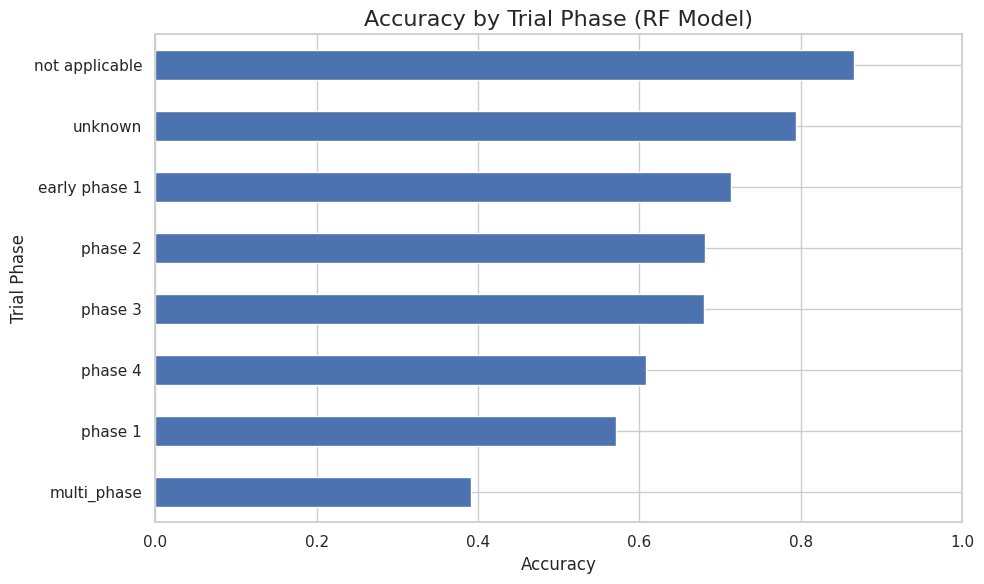


XG Model Analysis:
Accuracy by outcome category:
outcome_category
adverse_events          0.133333
biomarkers              0.000000
clinical_improvement    0.000000
mortality               0.000000
other                   1.000000
unknown                 0.000000
viral_clearance         0.000000
Name: xg_correct, dtype: float64


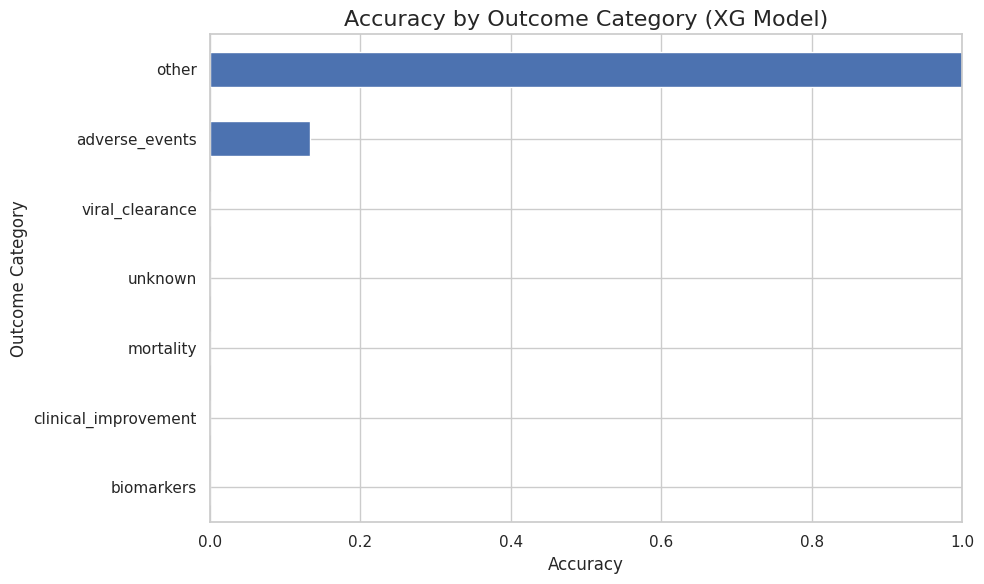

Accuracy by trial phase:
simplified_phase
early phase 1     0.714286
multi_phase       0.432432
not applicable    0.865854
phase 1           0.571429
phase 2           0.663717
phase 3           0.693333
phase 4           0.608696
unknown           0.813187
Name: xg_correct, dtype: float64


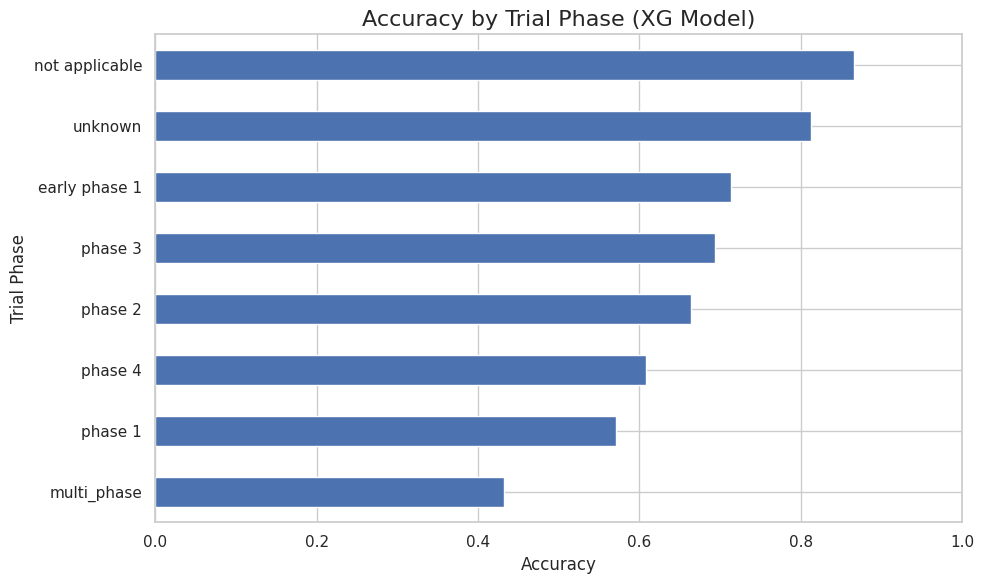

In [22]:
# Analyze characteristics of correctly vs incorrectly classified samples
for model in ["lr", "rf", "xg"]:
    print(f"\n{model.upper()} Model Analysis:")

    # Accuracy by outcome category
    accuracy_by_outcome = performance_analysis.groupby("outcome_category")[
        f"{model}_correct"
    ].mean()
    print(f"Accuracy by outcome category:")
    print(accuracy_by_outcome)

    plt.figure(figsize=(10, 6))
    accuracy_by_outcome.sort_values().plot(kind="barh")
    plt.title(f"Accuracy by Outcome Category ({model.upper()} Model)", fontsize=16)
    plt.xlabel("Accuracy", fontsize=12)
    plt.ylabel("Outcome Category", fontsize=12)
    plt.xlim(0, 1)
    plt.tight_layout()
    # plt.savefig(f"{model}_accuracy_by_outcome.png")
    plt.show()
    plt.close()

    # Accuracy by phase
    accuracy_by_phase = performance_analysis.groupby("simplified_phase")[
        f"{model}_correct"
    ].mean()
    print(f"Accuracy by trial phase:")
    print(accuracy_by_phase)

    plt.figure(figsize=(10, 6))
    accuracy_by_phase.sort_values().plot(kind="barh")
    plt.title(f"Accuracy by Trial Phase ({model.upper()} Model)", fontsize=16)
    plt.xlabel("Accuracy", fontsize=12)
    plt.ylabel("Trial Phase", fontsize=12)
    plt.xlim(0, 1)
    plt.tight_layout()
    # plt.savefig(f"{model}_accuracy_by_phase.png")
    plt.show()
    plt.close()


--- Model Comparison by Outcome Category ---


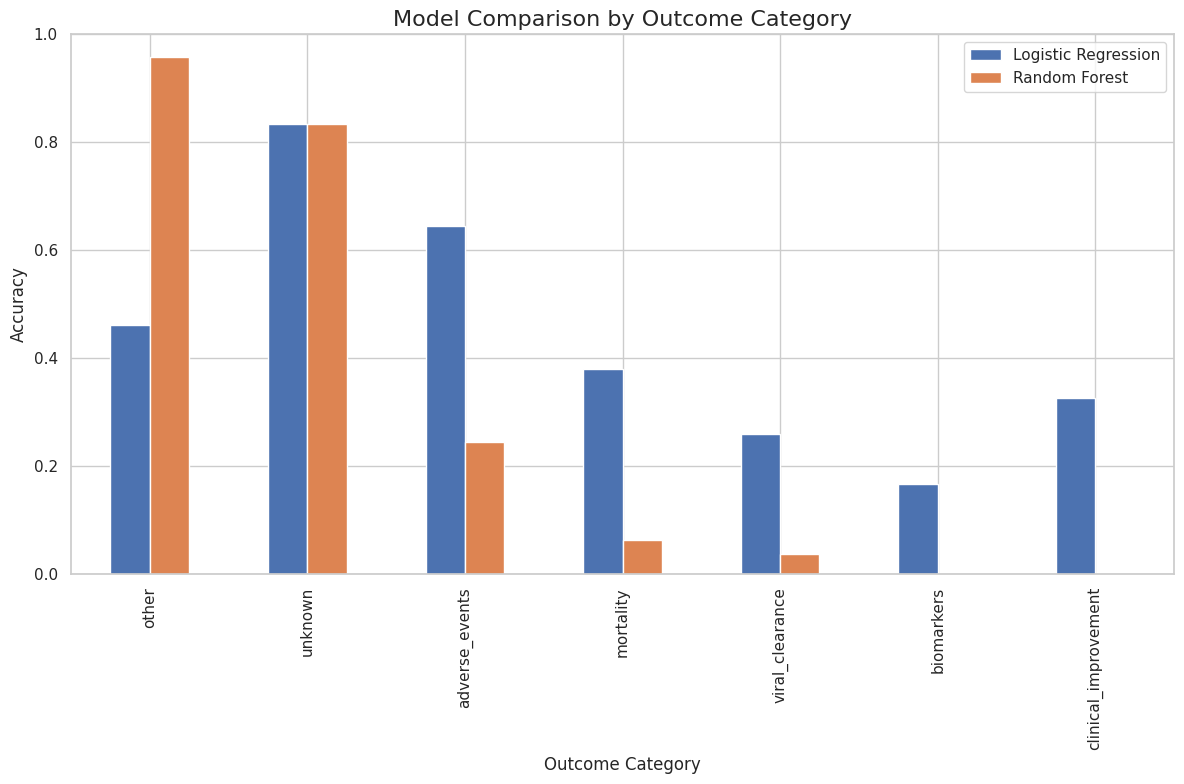

In [23]:
# 14. Model comparison by outcome category
print("\n--- Model Comparison by Outcome Category ---")

# Compare models across outcome categories
model_comparison = pd.DataFrame(
    {
        "Logistic Regression": performance_analysis.groupby("outcome_category")[
            "lr_correct"
        ].mean(),
        "Random Forest": performance_analysis.groupby("outcome_category")[
            "rf_correct"
        ].mean(),
    }
)

model_comparison = model_comparison.sort_values("Random Forest", ascending=False)
model_comparison.plot(kind="bar", figsize=(12, 8))
plt.title("Model Comparison by Outcome Category", fontsize=16)
plt.xlabel("Outcome Category", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1)
plt.tight_layout()
# plt.savefig("model_comparison_by_outcome.png")
plt.show()
plt.close()

In [24]:
print(
    "\nML model development complete. The Random Forest model achieved an accuracy of {:.2f}%, \nLogistic Regression model achieved {:.2f}%, \n XG boost model achieved {:.2f}%.".format(
        rf_accuracy * 100, lr_accuracy * 100, xgb_accuracy * 100
    )
)

print("\nSummary of findings:")
print(
    "1. The most predictive features were:",
    ", ".join(feature_importances["feature"].head(5).tolist()),
)
print(
    "2. The model performed best on these outcome categories:",
    ", ".join(model_comparison.head(3).index.tolist()),
)
print(
    "3. The model struggled most with these outcome categories:",
    ", ".join(model_comparison.tail(3).index.tolist()),
)

# Print correlation between condition count and prediction accuracy
condition_acc_corr = (
    performance_analysis[["condition_count", "lr_correct", "rf_correct"]]
    .corr()
    .iloc[0, 1:]
)
print(
    "4. Correlation between condition count and model accuracy:",
    condition_acc_corr.to_dict(),
)

# Print correlation between drug count and prediction accuracy
drug_acc_corr = (
    performance_analysis[["drug_count", "lr_correct", "rf_correct"]].corr().iloc[0, 1:]
)
print("5. Correlation between drug count and model accuracy:", drug_acc_corr.to_dict())


ML model development complete. The Random Forest model achieved an accuracy of 73.47%, 
Logistic Regression model achieved 44.93%, 
 XG boost model achieved 74.53%.

Summary of findings:
1. The most predictive features were: condition_count, sponsor_text_49, Status_available, condition_text_28, condition_text_1
2. The model performed best on these outcome categories: other, unknown, adverse_events
3. The model struggled most with these outcome categories: viral_clearance, biomarkers, clinical_improvement
4. Correlation between condition count and model accuracy: {'lr_correct': -0.13529793973836465, 'rf_correct': -0.14869403069294765}
5. Correlation between drug count and model accuracy: {'lr_correct': -0.07693893940560191, 'rf_correct': -0.05849773836067792}
